**IN PROGRESS**

## Import packages

In [1]:
import datetime
from pathlib import Path
import os
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from utils import check_integrity, load_data, datestring_to_timestamp
import mplfinance as mpf
import datetime
import numpy as np
import seaborn as sns

font = {'weight' : 'bold',
        'size'   : 14}

matplotlib.rc('font', **font)


In [2]:
data_dir = Path(os.getcwd(), '..', 'data').resolve()
intervals = ['1D', '1W', '3h', '30m']
time_ranges = [("2021-01-11", "2021-03-15"), ("2021-08-16", "2021-10-18")]
timestamp_ranges = [tuple(map(datestring_to_timestamp, tup)) for tup in time_ranges]
coins_pass_check_1_3 = {}   # "2021-01-12" - "2021-03-14"
coins_pass_check_8_10 = {}  # "2021-08-15" - "2021-10-16"

for interval in intervals:
    coins_pass_check_1_3[interval] = []
    coins_pass_check_8_10[interval] = []
    data_interval_dir = Path(data_dir, interval)
    files_path_list = [p for p in data_interval_dir.iterdir() if p.suffix == '.csv']
    for file_path in files_path_list:
        coin_code = file_path.name.split("_")[0]
        if check_integrity(*time_ranges[0], file_path) is not None:
            coins_pass_check_1_3[interval].append(coin_code)
        if check_integrity(*time_ranges[1], file_path) is not None:
            coins_pass_check_8_10[interval].append(coin_code)


In [3]:
print(f'The number of coins having all the data from {time_ranges[0][0]} to {time_ranges[0][1]}:')
{k:len(v) for k, v in coins_pass_check_1_3.items()}

The number of coins having all the data from 2021-01-11 to 2021-03-15:


{'1D': 73, '1W': 93, '3h': 46, '30m': 35}

In [4]:
print(f'The number of coins having all the data from {time_ranges[1][0]} to {time_ranges[1][1]}:')
{k:len(v) for k, v in coins_pass_check_8_10.items()}

The number of coins having all the data from 2021-08-16 to 2021-10-18:


{'1D': 117, '1W': 130, '3h': 3, '30m': 0}

**==>** Small granularity data has a large number of missing entries.

In [5]:
print(f'The number of coins having complete 1D data in both periods :')
coins = list(set(coins_pass_check_1_3['1D']).intersection(set(coins_pass_check_8_10['1D'])))
len(coins)

The number of coins having complete 1D data in both periods :


70

The following analysis will only focus on these coins.

The missing values of these coins will be filled with linear interpolation.

## Load data for further analysis

In [6]:
data_path = "../data"

data_1D_1_3_list = []
data_1D_8_10_list = []
interval = '1D'

for coin in coins:
    file_path = Path(data_path, interval, f"{coin}_USD_{interval}.csv").resolve()
    data_1D_1_3_list.append(load_data(time_ranges[0][0], time_ranges[0][1], file_path, fill_na=True, price='open,close,high,low'))
    data_1D_8_10_list.append(load_data(time_ranges[1][0], time_ranges[1][1], file_path, fill_na=True, price='open,close,high,low'))

data_1D_1_3 = pd.concat(data_1D_1_3_list)
data_1D_8_10 = pd.concat(data_1D_8_10_list)


## Time Series Visualization

In [7]:
interval_1D = '1D'
data_btc_etc_list = []
for coin in ['BTC', 'ETC']:
    file_path = Path(data_path, interval_1D, f"{coin}_USD_{interval_1D}.csv").resolve()
    data_btc_etc_list.append(load_data('2021-01-01', '2021-12-01', file_path, fill_na=True, price='open,close,high,low'))

data_btc_etc_df = pd.concat(data_btc_etc_list)

In [8]:
idx_list = []
for i in [0, 1]:
    for j in [0, 1]:
        idx_list.append(np.where(data_btc_etc_df[data_btc_etc_df.index.isin(['BTC'], level='coin')].datetime.values == np.datetime64(time_ranges[i][j]))[0])


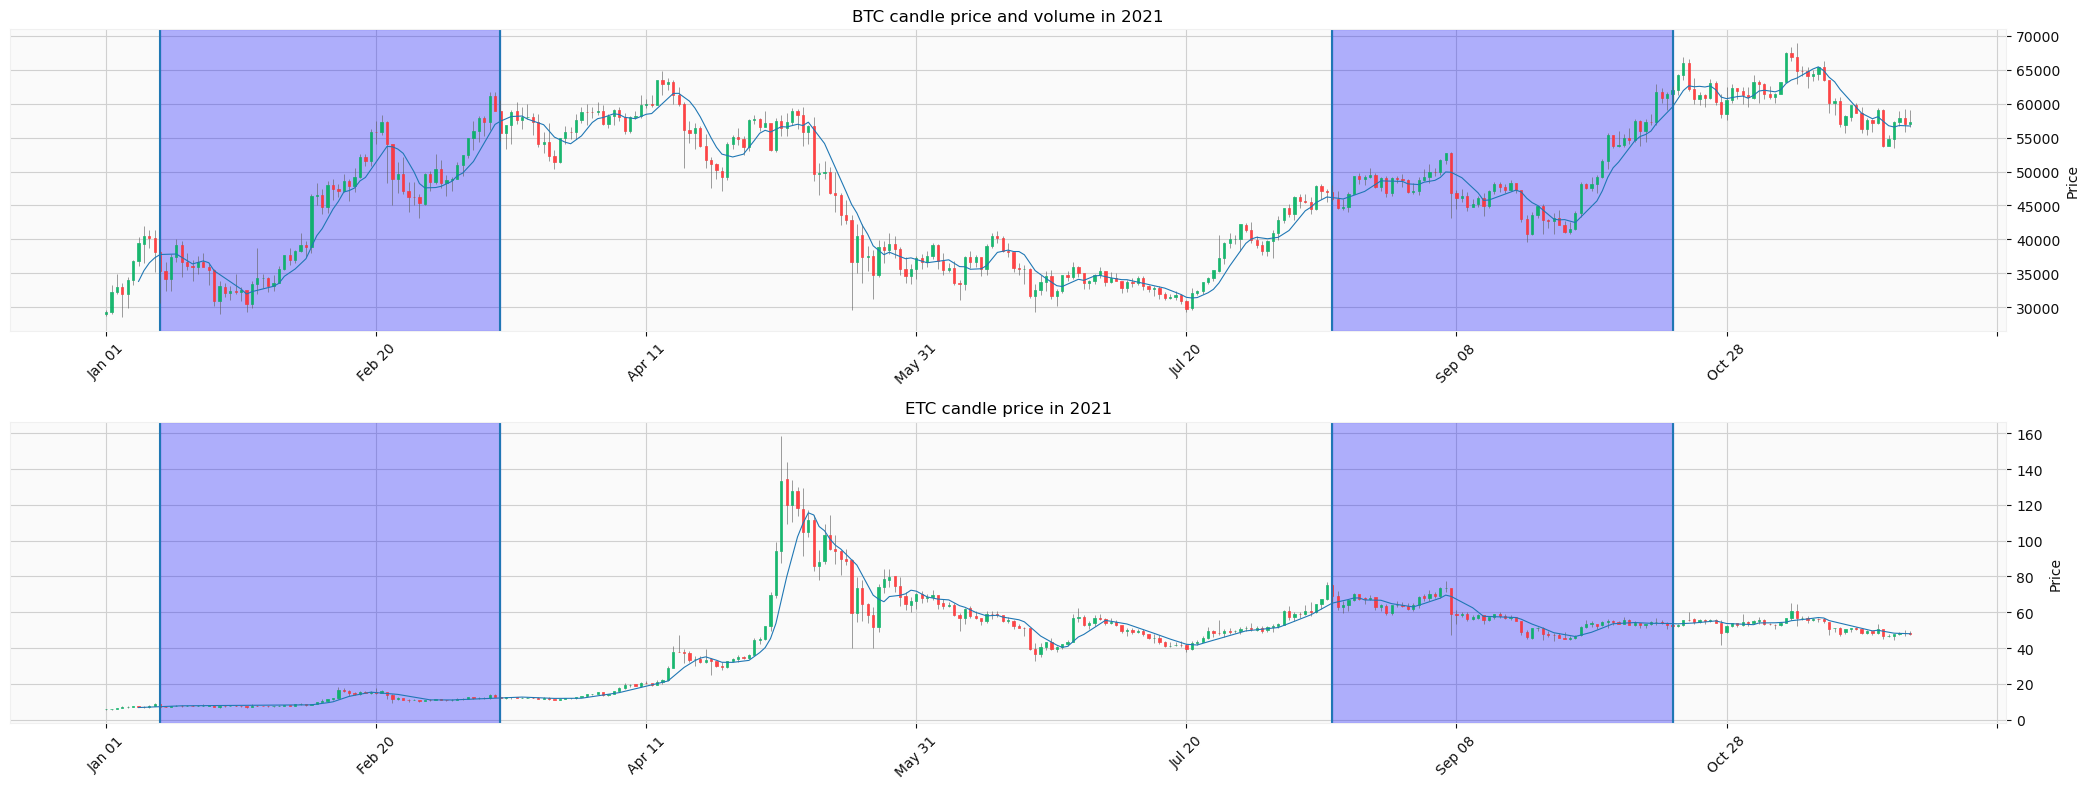

In [9]:
%matplotlib inline

# BTC candle price in 2021
fig = mpf.figure(figsize=(21,8))
ax1 = fig.add_subplot(2, 1, 1, style='yahoo')
for idx in idx_list:
    ax1.axvline(x=idx, ymin=0, ymax=1)
ax1.axvspan(int(idx_list[0]), int(idx_list[1]), alpha=0.3, color='blue')
ax1.axvspan(int(idx_list[2]), int(idx_list[3]), alpha=0.3, color='blue')
mpf.plot(data_btc_etc_df[data_btc_etc_df.index.isin(['BTC'], level='coin')].set_index('datetime'), type='candle', mav=7, ax=ax1, axtitle='BTC candle price and volume in 2021')
ax2 = fig.add_subplot(2, 1, 2, style='yahoo')
for idx in idx_list:
    ax2.axvline(x=idx, ymin=0, ymax=1)
ax2.axvspan(int(idx_list[0]), int(idx_list[1]), alpha=0.3, color='blue')
ax2.axvspan(int(idx_list[2]), int(idx_list[3]), alpha=0.3, color='blue')
mpf.plot(data_btc_etc_df[data_btc_etc_df.index.isin(['ETC'], level='coin')].set_index('datetime'), type='candle', mav=7, ax=ax2, axtitle='ETC candle price in 2021')
plt.tight_layout()
mpf.show()

The areas with the blue background are the time periods we will focus on.

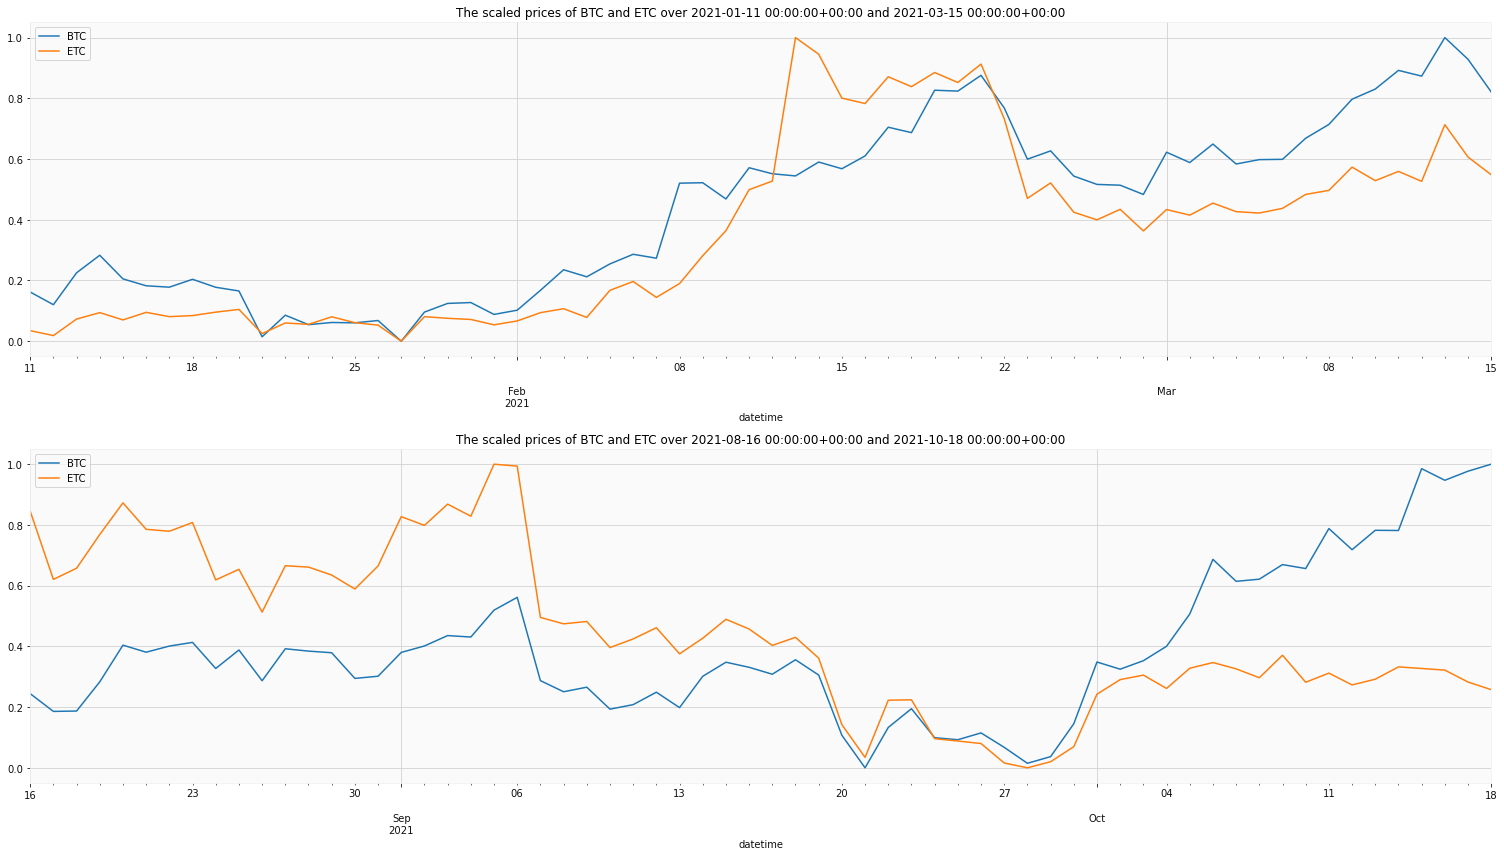

In [10]:
%matplotlib inline

fig, axs = plt.subplots(2, 1, figsize=(21, 12))
axs = axs.ravel()

plot_coins_num = 5
subplot_idx = 0
for df in [data_1D_1_3, data_1D_8_10]:
    for tick in ['BTC', 'ETC']:
        _tmp_df = df[df.index.isin([tick], level='coin')].set_index('datetime').copy()
        for price_col in ['open', 'close', 'high', 'low']:
            scaler = MinMaxScaler()
            _tmp_df[price_col] = scaler.fit_transform(_tmp_df[[price_col]])
        _tmp_df['close'].plot(label=tick, ax=axs[subplot_idx])
    axs[subplot_idx].legend()
    axs[subplot_idx].set_title(f'The scaled prices of BTC and ETC over {min(df.datetime)} and {max(df.datetime)}')
    subplot_idx += 1

fig.tight_layout()
plt.show()

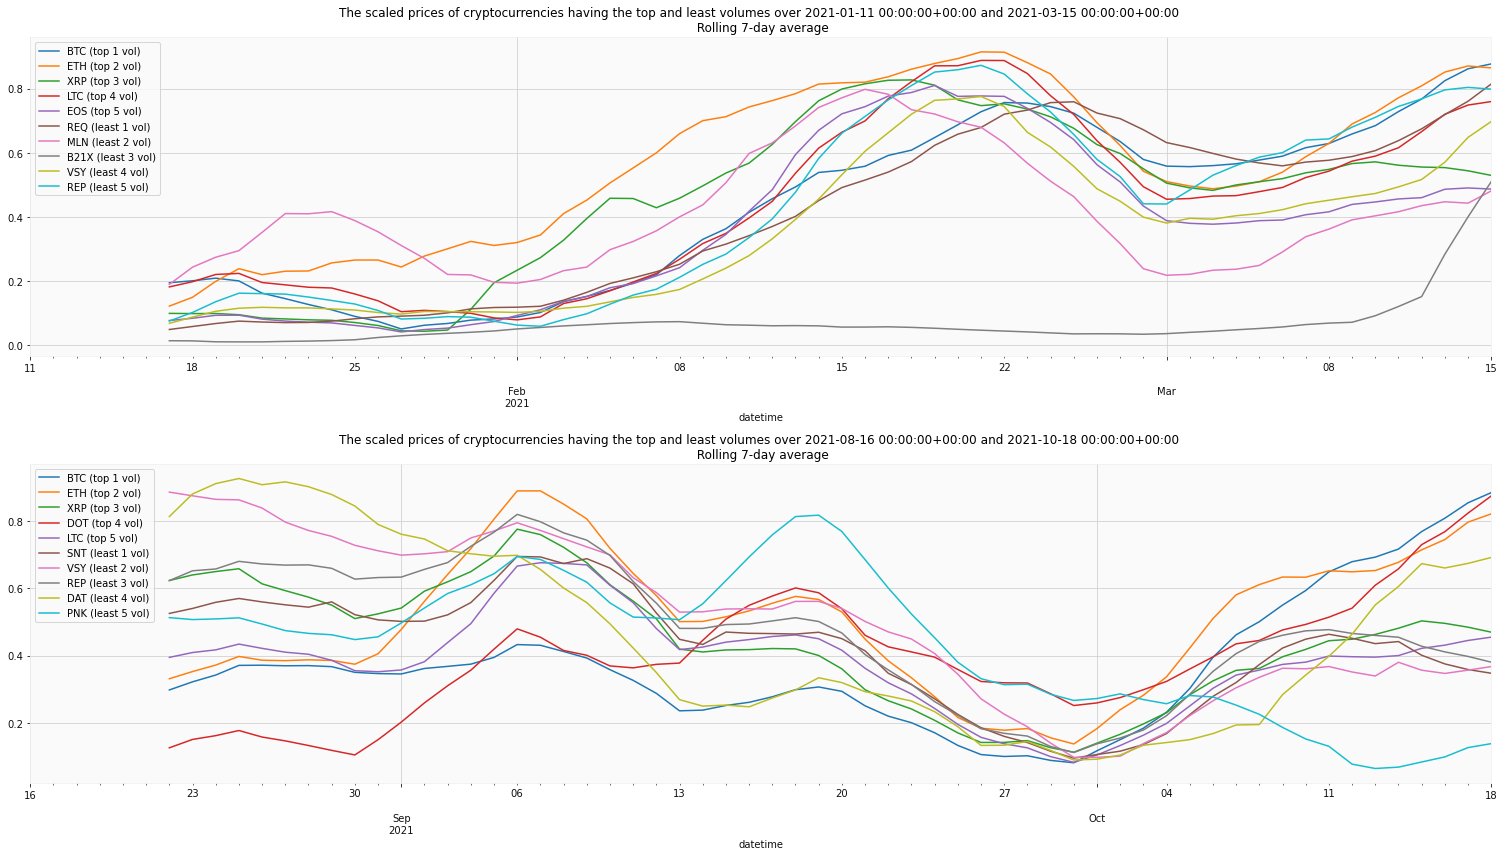

In [11]:
%matplotlib inline

fig, axs = plt.subplots(2, 1, figsize=(21, 12))
axs = axs.ravel()

subplot_idx = 0
for df in [data_1D_1_3, data_1D_8_10]:
    df['volumeUSD'] = df['volume'] * df['close']
    top_vol = df.groupby(level='coin').sum().volumeUSD.sort_values(ascending=False).index[:plot_coins_num]
    least_vol = df.groupby(level='coin').sum().volumeUSD.sort_values(ascending=True).index[:plot_coins_num]
    for idx, tick in enumerate(top_vol):
        scaler = MinMaxScaler()
        _tmp_df = df[df.index.isin([tick], level='coin')].set_index('datetime').copy()
        _tmp_df['price_std'] = scaler.fit_transform(_tmp_df[['close']])
        _tmp_df['price_std'].rolling(window=7).mean().plot(label=tick+f" (top {idx+1} vol)", ax=axs[subplot_idx])
    for idx, tick in enumerate(least_vol):
        scaler = MinMaxScaler()
        _tmp_df = df[df.index.isin([tick], level='coin')].set_index('datetime').copy()
        _tmp_df['price_std'] = scaler.fit_transform(_tmp_df[['close']])
        _tmp_df['price_std'].rolling(window=7).mean().plot(label=tick+f" (least {idx+1} vol)", ax=axs[subplot_idx])
    axs[subplot_idx].legend()
    axs[subplot_idx].set_title(f'The scaled prices of cryptocurrencies having the top and least volumes over {min(df.datetime)} and {max(df.datetime)} \n Rolling 7-day average')
    subplot_idx += 1
fig.tight_layout()
plt.show()

## Close price correlation heatmap

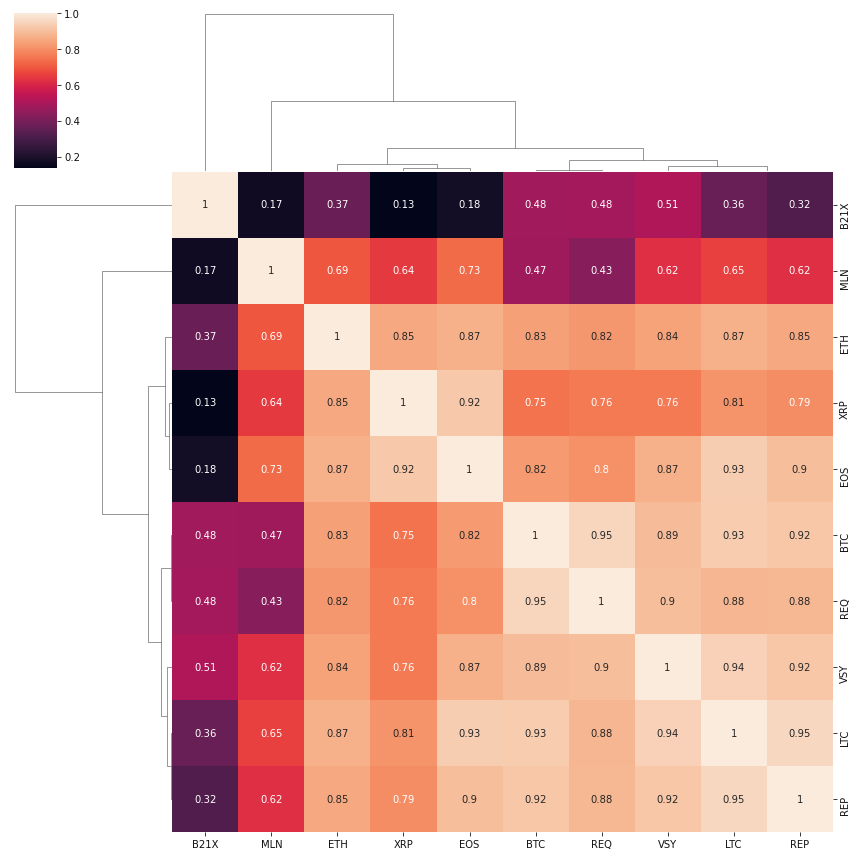

Volume high to low: ['BTC', 'ETH', 'XRP', 'LTC', 'EOS', 'REP', 'VSY', 'B21X', 'MLN', 'REQ']


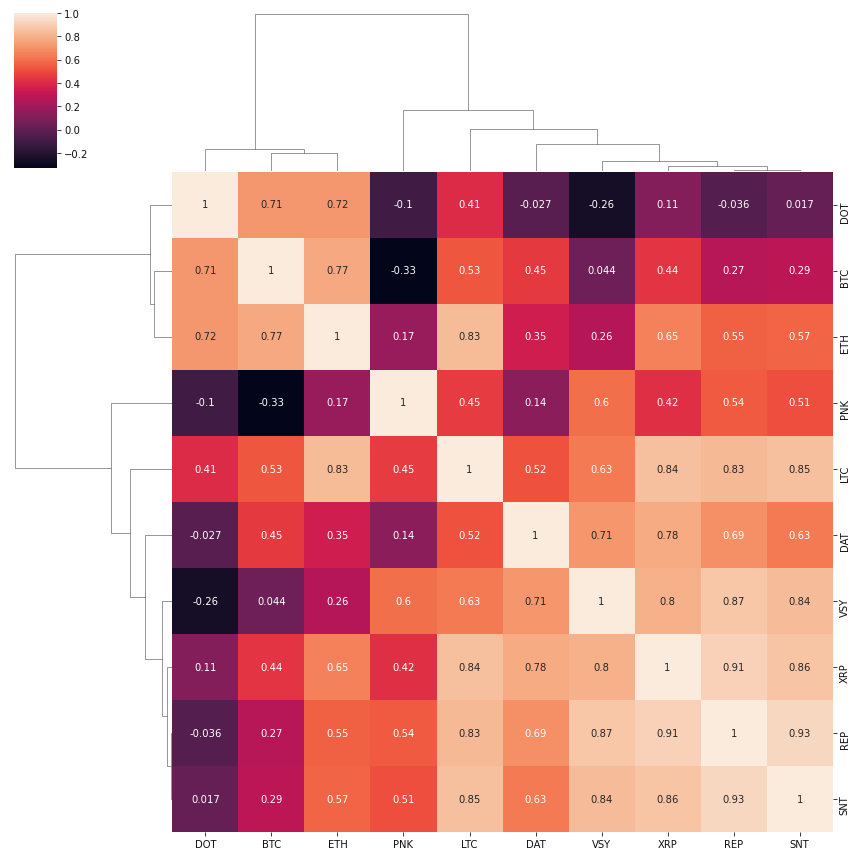

Volume high to low: ['BTC', 'ETH', 'XRP', 'DOT', 'LTC', 'PNK', 'DAT', 'REP', 'VSY', 'SNT']


In [15]:
%matplotlib inline

for df in [data_1D_1_3, data_1D_8_10]:
    _tmp_df_list = []
    df['volumeUSD'] = df['volume'] * df['close']
    top_vol = df.groupby(level='coin').sum().volumeUSD.sort_values(ascending=False).index[:plot_coins_num].to_list()
    least_vol = df.groupby(level='coin').sum().volumeUSD.sort_values(ascending=True).index[:plot_coins_num].to_list()
    least_vol.reverse()
    for tick in [*top_vol, *least_vol]:
        _tmp_df = df[df.index.isin([tick], level='coin')].set_index('datetime').copy()['close'].rename(f'{tick}')
        _tmp_df_list.append(_tmp_df)
    _tmp_df = pd.concat(_tmp_df_list, axis=1)
    g = sns.clustermap(_tmp_df.corr(), metric='correlation', annot=True, figsize=(12,12))
    plt.show()
    print("Volume high to low: " + str([*top_vol, *least_vol]))